In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from shapely.geometry import LineString
from shapely.geometry import Point,MultiPoint
from shapely.geometry import Polygon
import alphashape
import folium
import warnings
import sklearn
warnings.filterwarnings('ignore')

#### Read in Datasets

* entrances contains a shapefile of the metro entrance points for each station
* arcgis contains the station walksheds that were created previously

In [3]:
entrances = gpd.read_file("../../Data/entrances_shp")

arcgis = gpd.read_file("../../Data/walkshed 2023/walkshed_dissolved.shp")

In [4]:
entrances.head(2)

ID                 EName StnCode1 StnCode2  \
0  273  11TH ST NW & G ST NW      A01      C01   
1  274  13TH ST NW & G ST NW      A01      C01   

                                                Desc        Lat        Lon  \
0  Building Entrance from the southeast corner of...  38.898073 -77.026789   
1  Building Entrance from the southeast corner of...  38.898026 -77.029379   

  StnCode          Name                    geometry  
0     A01  Metro Center  POINT (-77.02679 38.89807)  
1     A01  Metro Center  POINT (-77.02938 38.89803)

In [2]:
miles_to_meters = 1609.34 #UTM is in metre

#### Preprocessing

* Define the old stations and the new silver line stations that need to be added
* Format them all as upper case

In [5]:
newstation=['Reston Town Center', 'Herndon', 'Innovation Center', 
            'WASHINGTON DULLES INTERNATIONAL AIRPORT', 'Loudoun Gateway','Ashburn']

In [6]:
otherstation=['METRO CENTER', 'FARRAGUT NORTH', 'DUPONT CIRCLE', 'WOODLEY PARK-ZOO/ADAMS MORGAN', 'CLEVELAND PARK', 'VAN NESS-UDC', 'TENLEYTOWN-AU', 'FRIENDSHIP HEIGHTS', 'BETHESDA', 'MEDICAL CENTER', 'GROSVENOR-STRATHMORE', 
 'NORTH BETHESDA', 'TWINBROOK', 'ROCKVILLE', 'SHADY GROVE', 'GALLERY PL-CHINATOWN', 'JUDICIARY SQUARE', 
 'UNION STATION', 'RHODE ISLAND AVE-BRENTWOOD', 'BROOKLAND-CUA', 'FORT TOTTEN', 'TAKOMA', 'SILVER SPRING', 
 'FOREST GLEN', 'WHEATON', 'GLENMONT', 'NOMA-GALLAUDET U', 'MCPHERSON SQUARE', 'FARRAGUT WEST', 
 'FOGGY BOTTOM-GWU', 'ROSSLYN', 'ARLINGTON CEMETERY', 'PENTAGON', 'PENTAGON CITY', 'CRYSTAL CITY', 
 'RONALD REAGAN WASHINGTON NATIONAL AIRPORT', 'BRADDOCK ROAD', 'KING ST-OLD TOWN', 'EISENHOWER AVENUE',
 'HUNTINGTON', 'FEDERAL TRIANGLE', 'SMITHSONIAN', "L'ENFANT PLAZA", 'FEDERAL CENTER SW', 'CAPITOL SOUTH',
 'EASTERN MARKET', 'POTOMAC AVE', 'STADIUM-ARMORY', 'MINNESOTA AVE', 'DEANWOOD', 'CHEVERLY', 'LANDOVER', 
 'NEW CARROLLTON', 'MT VERNON SQ 7TH ST-CONVENTION CENTER', 'SHAW-HOWARD U', 
 'U STREET/AFRICAN-AMER CIVIL WAR MEMORIAL/CARDOZO', 'COLUMBIA HEIGHTS', 'GEORGIA AVE-PETWORTH', 
 'WEST HYATTSVILLE', 'HYATTSVILLE CROSSING', 'COLLEGE PARK-U OF MD', 'GREENBELT', 
 'ARCHIVES-NAVY MEMORIAL-PENN QUARTER', 'WATERFRONT', 'NAVY YARD-BALLPARK', 'ANACOSTIA', 
 'CONGRESS HEIGHTS', 'SOUTHERN AVENUE', 'NAYLOR ROAD', 'SUITLAND', 'BRANCH AVE', 'BENNING ROAD',
 'CAPITOL HEIGHTS', 'ADDISON ROAD-SEAT PLEASANT', 'MORGAN BOULEVARD', 'DOWNTOWN LARGO', 'VAN DORN STREET',
 'FRANCONIA-SPRINGFIELD', 'COURT HOUSE', 'CLARENDON', 'VIRGINIA SQUARE-GMU', 'BALLSTON-MU', 'EAST FALLS CHURCH', 
 'WEST FALLS CHURCH', 'DUNN LORING-MERRIFIELD', 'VIENNA/FAIRFAX-GMU', 'MCLEAN', 'TYSONS', 'GREENSBORO', 
 'SPRING HILL', 'WIEHLE-RESTON EAST']

In [7]:
station_list = []
for stn in entrances.Name.unique():
    station = stn.upper()
    station_list.append(station)

In [8]:
newstation_list=station_list
new_list = []
for e in newstation_list:
    if e not in (otherstation):
        new_list.append(e)
newstation_list = new_list

In [9]:
item_list = station_list + newstation_list

- calculate walkshed for new stations

In [10]:
AS = []
alpha = 300 #adjust the threshold for ## because the coordinate system changed the alpha is 
                                       ##large number compared the website!
for cnt,station in enumerate(newstation_list):
    ashapes = []
    bufshapes = []
    print(cnt,station)
    for i in entrances[entrances.Name.str.upper().str.startswith(station)].index:
        single_entrance = entrances.loc[[i]]

        #cache the road network
        single_entrance_buf_geom = single_entrance.to_crs('EPSG:3857').buffer(miles_to_meters)
        single_entrance_buf = gpd.GeoDataFrame(single_entrance.copy(),geometry=single_entrance_buf_geom).to_crs("EPSG:4326")
        G = ox.graph_from_polygon(single_entrance_buf.geometry.values[0],network_type = "all")
        x,y = single_entrance.geometry.values[0].xy

        #extract subgraph
        center_node = ox.distance.nearest_nodes(G, x[0], y[0])
        G = ox.project_graph(G)
        # add an edge attribute for time in minutes required to traverse each edge
        #meters = travel_speed * 1000 / 60  # km per hour to m per minute
        for _, _, _, data in G.edges(data=True, keys=True):
            data["miles"] = data["length"] / miles_to_meters
        subgraph = nx.ego_graph(G, center_node, radius=0.5, distance="miles")

        #use alphashape of nodes from subgraph for walkshed shapes
        node_xy = [(data["lon"], data["lat"]) for node, data in subgraph.nodes(data=True)]
        ch = alphashape.alphashape(node_xy,alpha=alpha)
        walkshed = gpd.GeoDataFrame(single_entrance.copy(),geometry=[ch])
        ashapes.append(walkshed)
    #take the union of each entrance as the shape for the station
    union_as = pd.concat(ashapes).unary_union
    AS_walkshed = gpd.GeoDataFrame(arcgis[arcgis.Name_1.str.upper()==station][['Name_1','StnCode']].copy(),geometry=[union_as])
    AS.append(AS_walkshed)

0 RESTON TOWN CENTER
1 HERNDON
2 INNOVATION CENTER
3 WASHINGTON DULLES INTERNATIONAL AIRPORT
4 LOUDOUN GATEWAY
5 ASHBURN


#### Output

- save walkshed to shapefile for new stations

In [11]:
osmnx_walkshed = pd.concat(AS)
osmnx_walkshed = osmnx_walkshed.set_crs("EPSG:4326")
osmnx_walkshed.to_file('output/newwalkshed/walkshed_osmnx_alphashape.shp')
osmnx_walkshed.to_crs('EPSG:3857').to_file('output/newwalkshed/walkshed_osmnx_alphashape_epsg3857.shp')

In [12]:
m = folium.Map()
folium.GeoJson(data=osmnx_walkshed["geometry"]).add_to(m);

  #### Calculating walksheds for all stations

In [13]:
entrances = gpd.read_file("../../Data/RailStationsEntrances/RailStationEntrances2023.shp")
arcgis = gpd.read_file("../../Data/walkshed 2023/walkshed_dissolved.shp")

In [14]:
miles_to_meters = 1609.34 #UTM is in metre

In [15]:
station_list = []
for stn in entrances.STATIONNM.unique():
    station = stn.upper()
    station_list.append(station)

In [16]:
AS = []
alpha = 300 #adjust the threshold for ## because the coordinate system changed the alpha is 
                                       ##large number compared the website!
for cnt,station in enumerate(station_list):
    ashapes = []
    bufshapes = []
    print(cnt,station)
    for i in entrances[entrances.STATIONNM.str.upper().str.startswith(station)].index:
        single_entrance = entrances.loc[[i]]

        #cache the road network
        single_entrance_buf_geom = single_entrance.to_crs('EPSG:3857').buffer(miles_to_meters)
        single_entrance_buf = gpd.GeoDataFrame(single_entrance.copy(),geometry=single_entrance_buf_geom).to_crs("EPSG:4326")
        G = ox.graph_from_polygon(single_entrance_buf.geometry.values[0],network_type = "all")
        x,y = single_entrance.geometry.values[0].xy

        #extract subgraph
        center_node = ox.distance.nearest_nodes(G, x[0], y[0])
        G = ox.project_graph(G)
        # add an edge attribute for time in minutes required to traverse each edge
        #meters = travel_speed * 1000 / 60  # km per hour to m per minute
        for _, _, _, data in G.edges(data=True, keys=True):
            data["miles"] = data["length"] / miles_to_meters
        subgraph = nx.ego_graph(G, center_node, radius=0.5, distance="miles")

        #use alphashape of nodes from subgraph for walkshed shapes
        node_xy = [(data["lon"], data["lat"]) for node, data in subgraph.nodes(data=True)]
        ch = alphashape.alphashape(node_xy,alpha=alpha)
        walkshed = gpd.GeoDataFrame(single_entrance.copy(),geometry=[ch])
        ashapes.append(walkshed)
    #take the union of each entrance as the shape for the station
    union_as = pd.concat(ashapes).unary_union
    AS_walkshed = gpd.GeoDataFrame(arcgis[arcgis.Name_1.str.upper()==station][['Name_1','StnCode']].copy(),geometry=[union_as])
    AS.append(AS_walkshed)

0 EISENHOWER AVENUE
1 ARCHIVES-NAVY MEMORIAL-PENN QUARTER
2 SHAW-HOWARD UNIVERSITY
3 SOUTHERN AVENUE
4 U STREET/AFRICAN-AMER CIVIL WAR MEMORIAL/CARDOZO
5 CAPITOL SOUTH
6 EASTERN MARKET
7 FEDERAL TRIANGLE
8 FARRAGUT WEST
9 MCPHERSON SQUARE
10 FEDERAL CENTER SW
11 FOGGY BOTTOM-GWU
12 SMITHSONIAN
13 STADIUM-ARMORY
14 ROSSLYN
15 FRIENDSHIP HEIGHTS
16 SHADY GROVE
17 LANDOVER
18 DUNN LORING-MERRIFIELD
19 CHEVERLY
20 DEANWOOD
21 NEW CARROLLTON
22 ANACOSTIA
23 POTOMAC AVE
24 RONALD REAGAN WASHINGTON NATIONAL AIRPORT
25 CRYSTAL CITY
26 PENTAGON
27 PENTAGON CITY
28 NAVY YARD-BALLPARK
29 FRANCONIA-SPRINGFIELD
30 WIEHLE-RESTON EAST
31 DOWNTOWN LARGO
32 NORTH BETHESDA
33 HYATTSVILLE CROSSING
34 WASHINGTON DULLES INTERNATIONAL AIRPORT
35 TYSONS
36 CAPITOL HEIGHTS
37 BENNING ROAD
38 ADDISON ROAD-SEAT PLEASANT
39 MORGAN BOULEVARD
40 FARRAGUT NORTH
41 WHEATON
42 DUPONT CIRCLE
43 JUDICIARY SQUARE
44 BROOKLAND-CUA
45 EAST FALLS CHURCH
46 CLARENDON
47 BALLSTON-MU
48 COURT HOUSE
49 L'ENFANT PLAZA
50 VIRGIN

In [17]:
#save walkshed to shapefile
osmnx_walkshed = pd.concat(AS)
osmnx_walkshed = osmnx_walkshed.set_crs("EPSG:4326")
osmnx_walkshed.to_file('../../walkshed300/walkshed_osmnx_alphashape.geojson', driver='GeoJSON')
osmnx_walkshed.to_crs('EPSG:3857').to_file('../../walkshed300/walkshed_osmnx_alphashape_epsg3857.geojson', driver='GeoJSON')

In [18]:
###visualization (walkshed_buffer)

def add_points_to_folium(geo_df,fmap):
    geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in geo_df.geometry]

    # Iterate through list and add a marker for each volcano, color-coded by its type.
    for coordinates in geo_df_list:

        # Place the markers with the popup labels and data
        fmap.add_child(
            folium.Marker(
                location=coordinates,
                popup="Name: " + str(geo_df.Name[i]) + "<br>"

            )
        )

- load wmata dataset

In [19]:
wmata = gpd.read_file('../../Data/Walksheds020617/Walksheds020617')

In [20]:
station = ("DUNN LORING-MERRIFIELD")

In [21]:
ashapes = []
bufshapes = []
for i in entrances[entrances.STATIONNM.str.upper()==station].index:
    single_entrance = entrances.loc[[i]]
    
    #download the road network
    single_entrance_buf_geom = single_entrance.to_crs('EPSG:3857').buffer(miles_to_meters)
    single_entrance_buf = gpd.GeoDataFrame(single_entrance.copy(),geometry=single_entrance_buf_geom).to_crs("EPSG:4326")
    G = ox.graph_from_polygon(single_entrance_buf.geometry.values[0],network_type = "all")
    x,y = single_entrance.geometry.values[0].xy
    
    #extract subgraph
    center_node = ox.distance.nearest_nodes(G, x[0], y[0])
    G = ox.project_graph(G)
    # add an edge attribute for time in minutes required to traverse each edge
    #meters = travel_speed * 1000 / 60  # km per hour to m per minute
    for _, _, _, data in G.edges(data=True, keys=True):
        data["miles"] = data["length"] / miles_to_meters
    subgraph = nx.ego_graph(G, center_node, radius=0.5, distance="miles")
    
    #use alphashape of nodes from subgraph for walkshed shapes
    node_points = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
    node_xy = [(data["lon"], data["lat"]) for node, data in subgraph.nodes(data=True)]
    ch = alphashape.alphashape(node_xy,alpha=300)
    walkshed = gpd.GeoDataFrame(single_entrance.copy(),geometry=[ch])
    ashapes.append(walkshed)
    
    #use buffer for walkshed
    edge_buff=25
    node_buff=50
    nodes_gdf = gpd.GeoDataFrame({"id": list(subgraph.nodes)}, geometry=node_points)
    nodes_gdf = nodes_gdf.set_index("id")
    edge_lines = []
    for n_fr, n_to in subgraph.edges():
        f = nodes_gdf.loc[n_fr].geometry
        t = nodes_gdf.loc[n_to].geometry
        edge_lookup = G.get_edge_data(n_fr, n_to)[0].get("geometry", LineString([f, t]))
        edge_lines.append(edge_lookup)
    n = nodes_gdf.buffer(node_buff).geometry
    e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
    all_gs = list(n) + list(e)
    new_iso = gpd.GeoSeries(all_gs).unary_union
    new_iso = Polygon(new_iso.exterior)
    new_iso_gdf = gpd.GeoDataFrame(single_entrance.copy(),geometry=[new_iso],crs=G.graph["crs"])
    bufshapes.append(new_iso_gdf.to_crs("EPSG:4326"))

union_as = pd.concat(ashapes).unary_union
union_buf = pd.concat(bufshapes).unary_union

In [22]:
entrances['Name'] = entrances['STATIONNM']
m = folium.Map((union_as.centroid.y, union_as.centroid.x), zoom_start=13)
add_points_to_folium(entrances[entrances.STATIONNM.str.upper().str.startswith(station)],m)
folium.GeoJson(union_as,name='alphashape').add_to(m)
folium.GeoJson(wmata[wmata.Name.str.upper().str.startswith(station)].to_crs("EPSG:4326"),name='wmata',style_function=lambda x: {'color':"yellow",'fillColor':"yellow"}).add_to(m)
folium.GeoJson(arcgis[arcgis.Name.str.upper().str.startswith(station)],name='arcgis pro',style_function=lambda x: {'color':"green",'fillColor':"green"}).add_to(m)
folium.GeoJson(union_buf,name='road buffers',style_function=lambda x: {'color':"red",'fillColor':"red"}).add_to(m)
folium.map.LayerControl('topright', collapsed=False).add_to(m)
m

<hr/>

#### Visualize road network from one entrance

In [23]:
trip_miles = [0.5]

In [24]:
iso_colors = ox.plot.get_colors(n=len(trip_miles), cmap="plasma", start=1, return_hex=True)

In [25]:
i=228 #for greenbelt
single_entrance = entrances.loc[[i]]
single_entrance

OBJECTID  ID STATIONNM                                   DESCRPTION  \
228       618   0   ASHBURN  South pavilion entrance from south bus bay.   

               ENTRANCE_T                             ADDRESS  ENTRANCEID  \
228  ESCALATOR | STAIRWAY  43625 CROSON LN, ASHBURN, VA 20148           0   

    STATIONNAM STATIONCOD               ENTRANCENA  ... SERVICE__1 SERVICE__2  \
228    ASHBURN        N12  SOUTH PAVILION ENTRANCE  ...        NaN        NaN   

          ENTRANCE_1 SRVICELINE ACCESS_TYP RULEID  ENTRANCE_2  SERVICELIN  \
228  43625 CROSON LN          S     STREET     12         NaN           S   

                         geometry     Name  
228  POINT (69668.839 212692.303)  ASHBURN  

[1 rows x 37 columns]

In [26]:
#download the road network
single_entrance_buf_geom = single_entrance.to_crs('EPSG:3857').buffer(miles_to_meters)
single_entrance_buf = gpd.GeoDataFrame(single_entrance.copy(),geometry=single_entrance_buf_geom).to_crs("EPSG:4326")
G = ox.graph_from_polygon(single_entrance_buf.geometry.values[0],network_type = "all")
x,y = single_entrance.geometry.values[0].xy
#extract subgraph
center_node = ox.distance.nearest_nodes(G, x[0], y[0])
G = ox.project_graph(G)
# add an edge attribute for time in minutes required to traverse each edge
#meters = travel_speed * 1000 / 60  # km per hour to m per minute
for _, _, _, data in G.edges(data=True, keys=True):
    data["miles"] = data["length"] / miles_to_meters
subgraph = nx.ego_graph(G, center_node, radius=0.5, distance="miles")


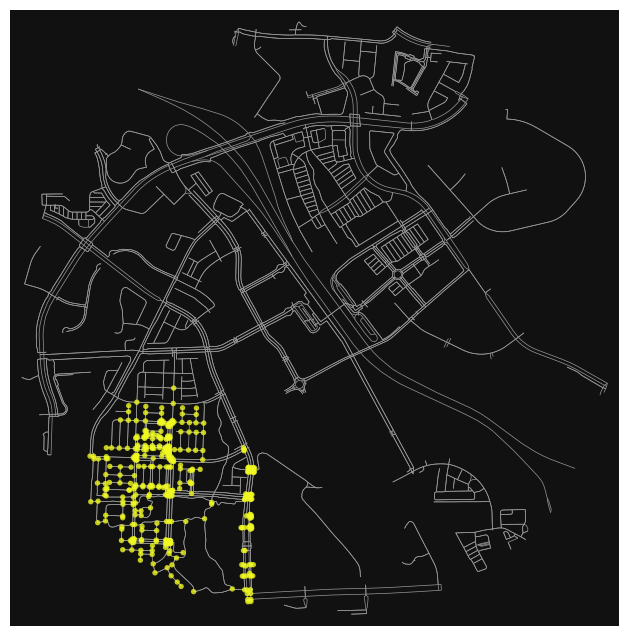

In [27]:
# color the nodes within the 0.5 mile then plot the street network
node_colors = {}
for trip_length, color in zip(sorted(trip_miles, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=trip_length, distance="miles")
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else "none" for node in G.nodes()]
ns = [15 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(
    G,
    node_color=nc,
    node_size=ns,
    node_alpha=0.8,
    edge_linewidth=0.5,
    edge_color="#999999",
)